# Optimización de Parámetros - DL - RNN

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import os
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent.parent.parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'gruas')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/gruas


In [3]:
import pandas as pd


In [4]:
import optuna
import datetime

In [5]:
from modulos.arima.gruas.general import format_timeseries, show_results_r2, arima_forecasting, total_forecasting, show_optimizer_results
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf


from modulos.LR.gruas.generals import make_lags
from modulos.DL.gruas.custom_models import ForecastinModel, cross_val_score_dl
from modulos.DL.gruas.optimizer import DLOptimizer

2021-11-20 21:38:16.752211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-20 21:38:16.752269: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
data = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
data.head()

,idArticulo,ventas,DescProducto,Periodo
0,tuerc,7,TUERCA,2021-05-01
1,tuerc,5,TUERCA,2020-12-01
2,tuerc,1,TUERCA,2020-11-01
3,tuerc,11,TUERCA,2020-09-01
4,tuerc,4,TUERCA,2020-06-01


In [7]:
# Pivotando las tablas y llenando de ceros las ventas que no existen.
df_time = format_timeseries(data)
df_time.tail()

idArticulo,arandel,bateriascanrec,filtrodeair,filtrodepresio,filtroderetorn,pern,soport,tuerc
Periodo,,,,,,,,
2021-06-01,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0
2021-07-01,0.0,1.0,2.0,2.0,2.0,0.0,1.0,0.0
2021-08-01,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-09-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2021-10-01,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0


## Baseline LR

In [8]:
   
idArticulo = 'filtrodeair'

ts = df_time[idArticulo].copy()

# Lag features
n_lags = 3
X = make_lags(ts, n_lags)
# Multistep targets
y = pd.DataFrame({
    'y': ts,
})

y, X = y.align(X, join='inner', axis=0)

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.tail(10).style.set_properties(['Targets'], **{'background-color': 'green'}) \
                   .set_properties(['Features'], **{'background-color': 'magenta'})
    

## Deel learning Model creation

In [9]:
forecasting = ForecastinModel((X.iloc[0].shape[0],1), dbsource='gruas')

2021-11-20 21:38:20.590540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 21:38:20.591140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-20 21:38:20.591329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-20 21:38:20.591470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-20 21:38:20.591597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1)            12          ['input_1[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 3)            0           ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 1)            0           ['lstm[0][0]']                   
                                                                                              

In [10]:
scores = cross_val_score_dl(ForecastinModel, X, y, cv=3, epochs=100, scoring='r2')
print(f"Cross validation results r2: {scores.mean()} ")

Cross validation results r2: 0.023239731788635254 


## Training a single model without optimization

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
forecasting = ForecastinModel((X.iloc[0].shape[0],1), dbsource='gruas', summary=False)
forecasting.train_model(X_train, y_train, X_test,  y_test, epochs=200, batch_size=32, workers=4, verbose= 0, callback=True, logs=True)

y_fit = pd.DataFrame(forecasting.model.predict(X), index=X.index, columns=y.columns)
#y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

/home/dave-linux/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


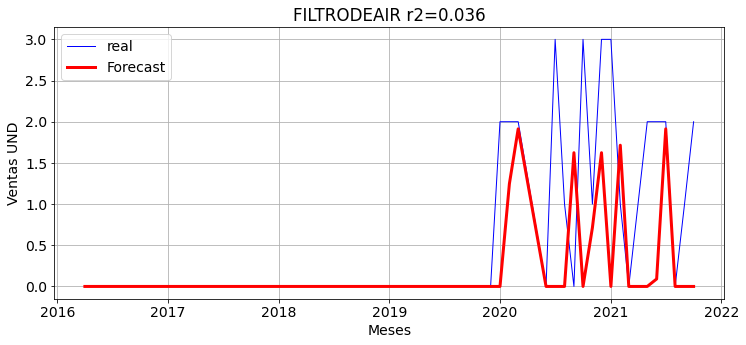

0.03562378562260826

In [12]:
show_results_r2(df_time, y_fit, idArticulo)


# Optimizar todos los Productos        

In [13]:
optimizer = DLOptimizer(df_time, iterations=7, data_path= DATA_PATH , model='DL', subpath = None, epochs=10)
optimizer.run( chunk_size=1)

/home/dave-linux/.local/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [1e-05, 0.001] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.00091].
  warnings.warn(
/home/dave-linux/.local/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [1e-05, 0.001] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.00091].
  warnings.warn(
/home/dave-linux/.local/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [1e-05, 0.001] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.00091].
  warnings.warn(
/home/dave-linux/.local/lib/python3.8/site-packages/optuna/distributions.py:545: UserWarning: The distribution is specified by [1e-05, 0.001] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.00091].
  war

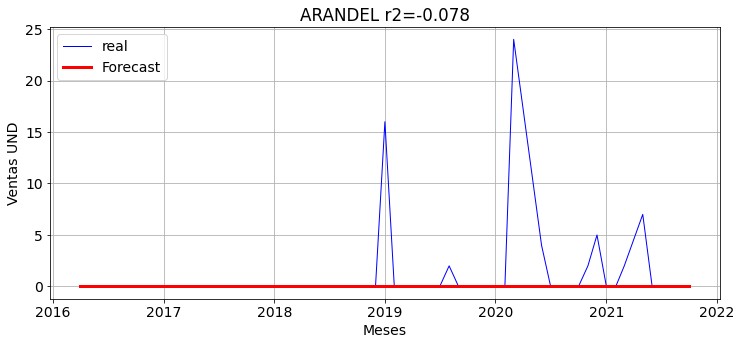

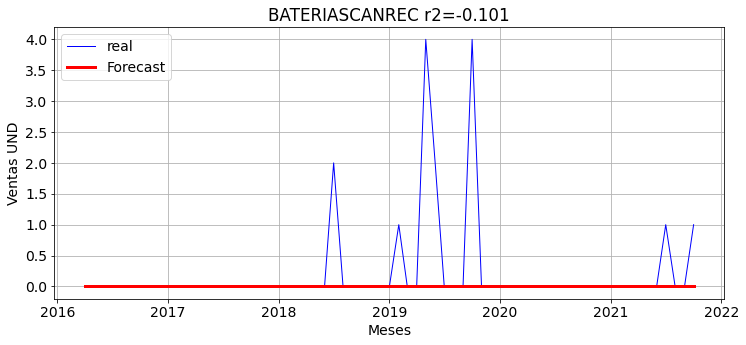

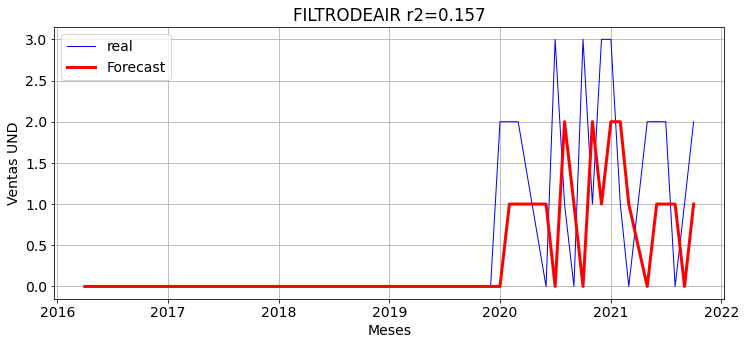

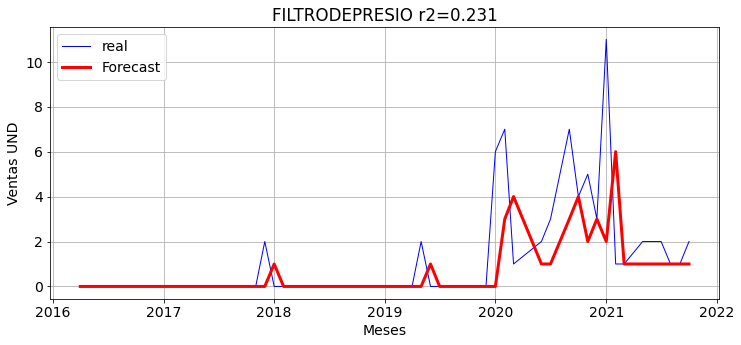

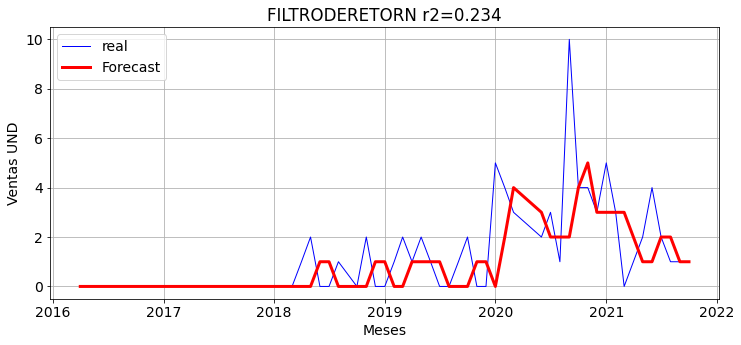

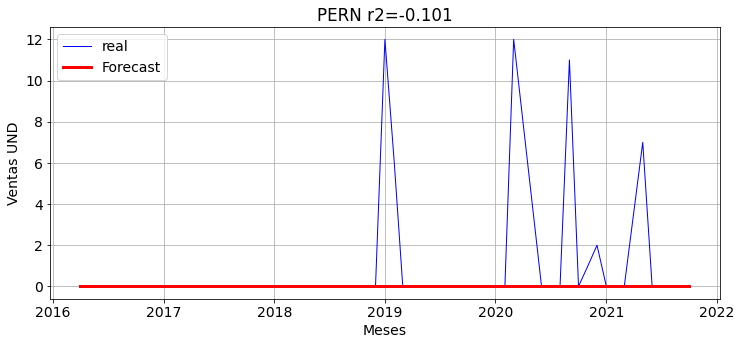

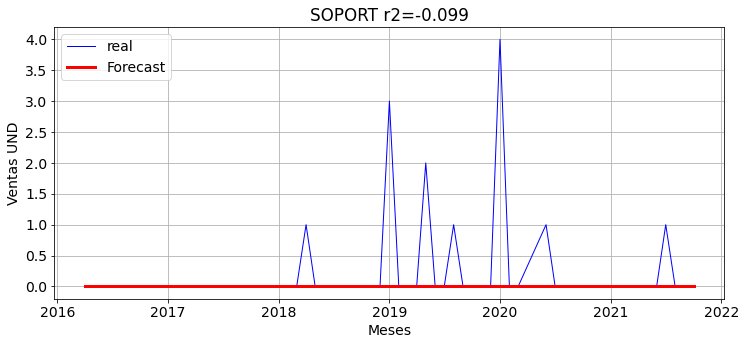

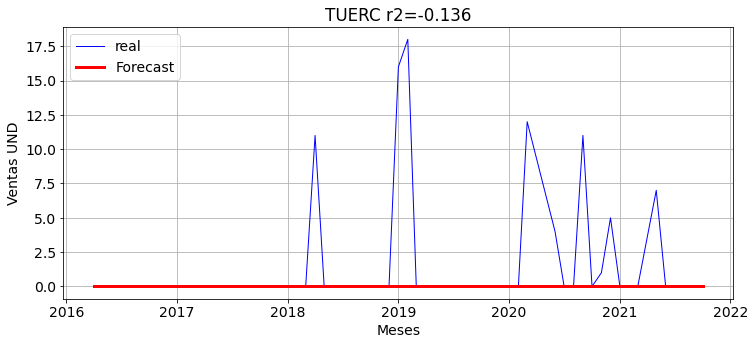

In [15]:
optimizer.print_results()